# Data Exploration

**Purpose:** Initial data exploration and quality assessment  
**Author:** Devbrew LLC  
**Last Updated:** October 18, 2025
**Status:** In Development  
**License:** Apache 2.0 (Code) | Non-commercial (Data)

---

## Dataset License Notice

This notebook uses the **IEEE-CIS Fraud Detection dataset** from Kaggle.

**Dataset License:** Non-commercial research use only
- You must download the dataset yourself from [Kaggle IEEE-CIS Competition](https://www.kaggle.com/c/ieee-fraud-detection)
- You must accept the competition rules before downloading
- Cannot be used for commercial purposes
- Cannot redistribute the raw dataset

**Setup Instructions:** See [`../data_catalog/README.md`](../data_catalog/README.md) for download instructions.

**Code License:** This notebook's code is licensed under Apache 2.0 (open source).

---

## Notebook Configuration

### Load packages and configure environment

We configure the Python environment with standardized display settings, plotting styles, and a fixed random seed for reproducibility. This ensures consistent results across runs and professional-quality visualizations.

These settings establish the foundation for all subsequent analysis and enable reliable comparison of results.

In [1]:
import warnings
from pathlib import Path
import json
from typing import Optional, Tuple

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Plotting configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("\nEnvironment configured successfully")
print(f"pandas: {pd.__version__}")
print(f"numpy: {np.__version__}")


Environment configured successfully
pandas: 2.3.3
numpy: 2.3.3


### Path Configurations

We define the project directory structure using pathlib for OS-agnostic path handling and implement validation checks to verify dataset availability before analysis begins. The validation function provides clear feedback on missing files and references setup documentation.

This configuration pattern ensures portability across development environments and fails fast if data prerequisites are not met.

In [2]:
# Project paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "data_catalog"
PROCESSED_DIR = DATA_DIR / "processed"
NOTEBOOKS_DIR = PROJECT_ROOT / "notebooks"

# Dataset paths
IEEE_CIS_DIR = DATA_DIR / "ieee-fraud" # IEEE-CIS Fraud Detection Dataset
PAYSIM_DIR = DATA_DIR / "paysim" # PaySim Dataset
OFAC_DIR = DATA_DIR / "ofac" # OFAC Sanctions Dataset

# Create output directories
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)


# Validate data availability
def validate_data_path() -> dict:
    """Validate that required datasets exists"""
    paths_status = {
        'IEEE Train Transaction': (IEEE_CIS_DIR / "train_transaction.csv").exists(),
        'IEEE Train Identity': (IEEE_CIS_DIR / "train_identity.csv").exists(),
        'IEEE Test Transaction': (IEEE_CIS_DIR / "test_transaction.csv").exists(),
        'IEEE Test Identity': (IEEE_CIS_DIR / "test_identity.csv").exists(),
        'PaySim': (PAYSIM_DIR / "PS_20174392719_1491204439457_log.csv").exists(),
        'OFAC SDN': (OFAC_DIR / "sdn" / "sdn.csv").exists(),
        'OFAC SDN ADD': (OFAC_DIR / "sdn" / "add.csv").exists(),
        'OFAC SDN ALT': (OFAC_DIR / "sdn" / "alt.csv").exists(),
        'OFAC SDN COMMENTS': (OFAC_DIR / "sdn" / "sdn_comments.csv").exists(),
        'OFAC Consolidated': (OFAC_DIR / "consolidated" / "cons_prim.csv").exists(),
        'OFAC Consolidated ADD': (OFAC_DIR / "consolidated" / "cons_add.csv").exists(),
        'OFAC Consolidated ALT': (OFAC_DIR / "consolidated" / "cons_alt.csv").exists(),
        'OFAC Consolidated COMMENTS': (OFAC_DIR / "consolidated" / "cons_comments.csv").exists(),
    }

    print("\nData Availability Check:")
  
    for name, exists in paths_status.items():
        status = "Found" if exists else "Missing"
        print(f"{name}: {status}")

    all_exist = all(paths_status.values())
    if not all_exist:
        print("\n[WARNING] Some datasets are missing. Check data_catalog/README.md")
    else: 
        print("\nAll required datasets are found.")

    return paths_status    

paths_status = validate_data_path()


Data Availability Check:
IEEE Train Transaction: Found
IEEE Train Identity: Found
IEEE Test Transaction: Found
IEEE Test Identity: Found
PaySim: Found
OFAC SDN: Found
OFAC SDN ADD: Found
OFAC SDN ALT: Found
OFAC SDN COMMENTS: Found
OFAC Consolidated: Found
OFAC Consolidated ADD: Found
OFAC Consolidated ALT: Found
OFAC Consolidated COMMENTS: Found

All required datasets are found.


## Helper Functions

We define reusable utilities for data loading, quality assessment, and visualization to ensure consistent analysis across all datasets. These functions implement error handling, type hints, and standardized output formats following the DRY (Don't Repeat Yourself) principle.

These utilities form the analytical foundation for all subsequent exploratory data analysis and enable reproducible, maintainable code.

In [3]:
# Load dataset
def load_dataset(
    file_path: Path,
    nrows: Optional[int] = None,
    parse_dates: Optional[list] = None
) -> Optional[pd.DataFrame]:
    """
    Load CSV dataset with error handling and logging.

    Args:
        file_path: Path to CSV file
        nrows: Number of rows to load (None = all)
        parse_dates: Columns to parse as datetime
    
    Returns:
        Dataframe if successful, None if error

    Example:
        >>> df = load_dataset(IEEE_DIR / "train_transaction.csv", nrows=10000)
    """
    try:
        df = pd.read_csv(file_path, nrows=nrows, parse_dates=parse_dates)
        print(f"\nLoaded dataset {file_path.name}")
        print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]:,} columns")
        print(f"Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        return df
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return None
    except Exception as e:
        print(f"Error loading {file_path.name}: {str(e)}")
        return None


# Analyze data quality
def analyze_data_quality(df: pd.DataFrame, name: str) -> dict:
    """
    Comprehensive data quality assessment.

    Args:
        df: DataFrame to analyze
        name: Dataset name for reporting

    Returns:
        Dictionary of quality metrics
    """
    print(f"\nData Quality Report: {name}")
        

    # Basic info
    n_rows, n_cols = df.shape
    memory_mb = df.memory_usage(deep=True).sum() / 1024**2

    print(f"\nDataset Overview:")
    print(f" • Rows: {n_rows:,}")
    print(f" • Columns: {n_cols}")
    print(f" • Memory: {memory_mb:.2f} MB")

    # Data types
    print(f"\nColumn Types:")
    dtype_counts = df.dtypes.value_counts()
    for dtype, count in dtype_counts.items():
        print(f" • {dtype}: {count} columns")
    
    # Missing values
    missing = df.isnull().sum()
    missing_pct = (missing / len(df) * 100)
    missing_df = pd.DataFrame({
        'Count': missing[missing > 0],
        'Percent': missing_pct[missing > 0]
    }).sort_values('Percent', ascending=False)

    print(f"\nMissing Values:")
    if len(missing_df) > 0:
        print(f" • Total missing values: {missing_df['Count'].sum():,}")
        print(f" • Columns with missing values: {len(missing_df)}/{n_cols}")
        print(f" • Top 5 missing columns:")
        for col, row in missing_df.head(5).iterrows():
            print(f"    - {col}: {row['Count']:,} ({row['Percent']:.2f}%)")
    else:
        print("No missing values")

    # Duplicate
    n_duplicates = df.duplicated().sum()
    dup_pct = (n_duplicates / len(df) * 100)
    print(f"\nDuplicates:")
    print(f" • Duplicate rows: {n_duplicates:,} ({dup_pct:.2f}%)")

    # Return metrics for programmtic use
    return {
        'n_rows': n_rows,
        'n_cols': n_cols,
        'memory_mb': memory_mb,
        'missing_cols': len(missing_df),
        'missing_pct_max': missing_pct.max() if len(missing_pct) > 0 else 0,
        'n_duplicates': n_duplicates,
    }

# Analyze target variable
def analyze_target_variable(
    df: pd.DataFrame, 
    target_col: str, 
    title: str
) -> Tuple[float, dict]:
    """
    Analyze and visualize binary target variable.

    Args:
        df: DataFrame containing target
        target_col: Name of target column
        title: Plot title

    Returns:
        Tuple of (fraud_rate, metrics_dict)
    """
    # Calculate metrics
    total = len(df)
    fraud_count = df[target_col].sum()
    fraud_rate = (fraud_count / total) * 100
    imbalance_ratio = total / fraud_count if fraud_count > 0 else float('inf')

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Count plot
    counts = df[target_col].value_counts().sort_index()
    colors = ['#2ecc71', '#e74c3c'] # Green for legit, red for fraud
    counts.plot(kind='bar', ax=axes[0], color=colors, edgecolor='black', alpha=0.8)
    axes[0].set_title(f"{title} - Distribution", fontsize=12)
    axes[0].set_xlabel('Class (0=Legitimate, 1=Fraud)', fontsize=10)
    axes[0].set_ylabel('Count', fontsize=10)
    axes[0].tick_params(axis='x', rotation=0)
    axes[0].grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for i, v in enumerate(counts):
        axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')
    
    # Percentage pie chart
    axes[1].pie(
        counts, 
        labels=['Legitimate', 'Fraud'], 
        colors=colors,
        autopct='%1.2f%%', 
        startangle=90,
        explode=(0, 0.1), # Explode fraud slice
        shadow=True,
    )

    plt.tight_layout()
    plt.show()

    # Print metrics
    print(f"\nTarget Variable Analysis: {target_col}")
    print(f" • Total transactions: {total:,}")
    print(f" • Fraudulent: {fraud_count:,} ({fraud_rate:.2f}%)")
    print(f" • Legitimate: {total - fraud_count:,} ({100 - fraud_rate:.2f}%)")
    print(f" • Fraud rate: {fraud_rate:.2f}%")
    print(f" • Class imbalance ratio: 1:{imbalance_ratio:.0f}")

    if fraud_rate < 1:
        print(f"\n[WARNING] Highly imbalanced - consider SMOTE/undersampling")

    metrics = {
        'total': total,
        'fraud_count': fraud_count,
        'fraud_rate': fraud_rate,
        'imbalance_ratio': imbalance_ratio,
    }

    return fraud_rate, metrics

# Plot numeric features 
def plot_numeric_distribution(
    df: pd.DataFrame,
    col: str,
    target_col: str,
    log_scale: bool = False,
) -> None:
    """
    Plot distribution of numeric feature by target class.

    Args:
        df: DataFrame containing data
        col: Numeric column to plot
        target_col: Binary target column
        log_scale: Use log scale for skewed distributions
    """
    fig, axes = plt.subplots(1,2, figsize=(14, 5))

    # Overall distribution
    df[col].hist(bins=50, ax=axes[0], edgecolor='black', alpha=0.7)
    axes[0].set_title(f"{col} - Overall Distribution")
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')
    if log_scale:
        axes[0].set_yscale('log')

    # By target class
    df.boxplot(column=col, by=target_col, ax=axes[1])
    axes[1].set_title(f"{col} - By Target Class")
    axes[1].set_xlabel(f"{target_col} (0=Legit, 1=Fraud)")
    axes[1].set_ylabel(col)
    plt.suptitle('') # Remove default title

    plt.tight_layout()
    plt.show()

    # Statistical comparison
    legit_status = df[df[target_col] == 0][col].describe()
    fraud_status = df[df[target_col] == 1][col].describe()

    print(f"\n{col} Statistics")
    print(f"Legitimate - Mean: {legit_status['mean']:.2f}, Median: {legit_status['50%']:.2f}")
    print(f"Fraudulent - Mean: {fraud_status['mean']:.2f}, Median: {fraud_status['50%']:.2f}")
    
    
print("\nHelper functions loaded")


Helper functions loaded


## Validate Helper Functions

We implement an automated validation test for all helper functions with a small data sample (1,000 rows) from IEEE-CIS training data. These tests verify return types, required metrics, and graceful error handling to ensure reliability before processing full datasets.

This validation suite establishes confidence in our analytical utilities and prevents downstream failures in the analysis pipeline.


Loaded dataset train_transaction.csv
Shape: 1,000 rows x 394 columns
Memory: 3.52 MB

Data Quality Report: validation_test

Dataset Overview:
 • Rows: 1,000
 • Columns: 394
 • Memory: 3.52 MB

Column Types:
 • float64: 376 columns
 • object: 14 columns
 • int64: 4 columns

Missing Values:
 • Total missing values: 159,304
 • Columns with missing values: 284/394
 • Top 5 missing columns:
    - D7: 934.0 (93.40%)
    - dist2: 908.0 (90.80%)
    - D13: 863.0 (86.30%)
    - D8: 861.0 (86.10%)
    - D14: 861.0 (86.10%)

Duplicates:
 • Duplicate rows: 0 (0.00%)


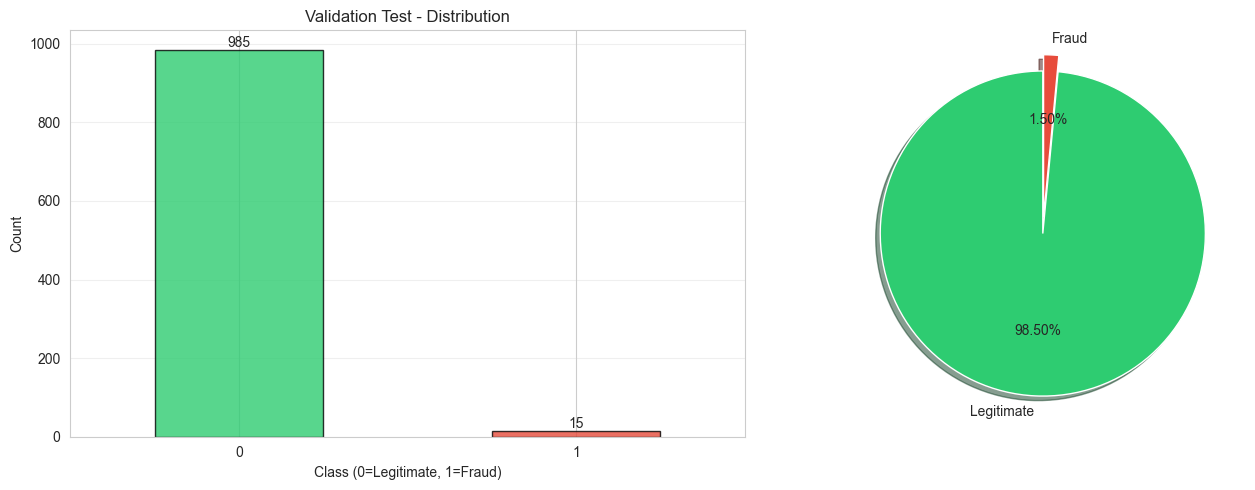


Target Variable Analysis: isFraud
 • Total transactions: 1,000
 • Fraudulent: 15 (1.50%)
 • Legitimate: 985 (98.50%)
 • Fraud rate: 1.50%
 • Class imbalance ratio: 1:67

All helper functions validated successfully


In [4]:
# Validate helper functions
def validate_helper_functions() -> bool:
    """
    Validate that all helper functions work correctly.
    Uses a small sample to minimize overhead.

    Returns:
        bool: True if all validations pass
    """
    try:
        # Test data loading
        test_df = load_dataset(IEEE_CIS_DIR / "train_transaction.csv", nrows=1000)

        if test_df is None or len(test_df) == 0:
            raise ValueError("load_dataset returned empty DataFrame")

        # Test data quality analysis
        quality_metrics = analyze_data_quality(test_df, "validation_test")
        if not isinstance(quality_metrics, dict):
            raise ValueError("analyze_data_quality did not return metrics")
        
        # Verify required metrics exist
        required_keys = ['n_rows', 'n_cols', 'memory_mb']

        if not all(key in quality_metrics for key in required_keys):
            raise ValueError("Missing required quality metrics")
        
        # Test target analysis (if isFraud column exists)
        if "isFraud" in test_df.columns:
            fraud_rate, metrics = analyze_target_variable(
                test_df, 
                "isFraud",
                "Validation Test"
            )

            if not isinstance(fraud_rate, float) or fraud_rate is None:
                raise ValueError("analyze_target_variable returned invalid data")
        
        # Clean up
        del test_df

        return True

    except FileNotFoundError as e:
        print(f"\nValidation failed. Data file not found: {e}")
        return False
    except Exception as e:
        print(f"\nValidation failed. Unexpected error: {e}")
        return False

# Run validation
if validate_helper_functions():
    print("\nAll helper functions validated successfully")
else:
    print("\nValidation failed. Check errors above")

## Load IEEE-CIS Dataset

We load a 50,000-transaction sample from IEEE-CIS for memory-efficient exploration with rapid iteration. The transaction and identity datasets are merged using a left join (1:1 validation), preserving all transactions and revealing ~33% identity feature coverage.

This sampling approach balances computational efficiency with analytical depth while exposing critical data sparsity patterns.

In [5]:
print("\nLoading IEEE-CIS Fraud Detection Dataset")

# Load transaction data (sample for exploration)
SAMPLE_SIZE = 50_000 # Using underscore for readability 
print(f"Loading {SAMPLE_SIZE:,} samples transaction...\n")

ieee_train_txn = load_dataset(
    IEEE_CIS_DIR / "train_transaction.csv",
    nrows=SAMPLE_SIZE,
)
# Load identity data (sample for exploration)
ieee_train_id = load_dataset(
    IEEE_CIS_DIR / "train_identity.csv",
    nrows=SAMPLE_SIZE,
)

# Merge datasets
if ieee_train_txn is not None and ieee_train_id is not None:
    print("\nMerging transaction and identity data...")
    ieee_train = ieee_train_txn.merge(
        ieee_train_id, 
        on="TransactionID", 
        how="left", # Left join to keep all transactions
        validate="1:1" # Ensure 1-to-1 relationship
    )
    print(f"\nMerged dataset shape: {ieee_train.shape}")
    print(f"\nIdentify match rate: {(~ieee_train[ieee_train_id.columns[1]].isnull()).mean()*100:2f}%")

    # Data quality analysis
    ieee_metrics = analyze_data_quality(ieee_train, "IEEE-CIS Fraud Detection")
    
else:
    print("Failed to load IEEE-CIS dataset")
    ieee_train = None


Loading IEEE-CIS Fraud Detection Dataset
Loading 50,000 samples transaction...


Loaded dataset train_transaction.csv
Shape: 50,000 rows x 394 columns
Memory: 176.06 MB

Loaded dataset train_identity.csv
Shape: 50,000 rows x 41 columns
Memory: 55.69 MB

Merging transaction and identity data...

Merged dataset shape: (50000, 434)

Identify match rate: 32.912000%

Data Quality Report: IEEE-CIS Fraud Detection

Dataset Overview:
 • Rows: 50,000
 • Columns: 434
 • Memory: 217.49 MB

Column Types:
 • float64: 399 columns
 • object: 31 columns
 • int64: 4 columns

Missing Values:
 • Total missing values: 9,816,044
 • Columns with missing values: 359/434
 • Top 5 missing columns:
    - id_24: 49,441.0 (98.88%)
    - id_25: 49,402.0 (98.80%)
    - id_21: 49,396.0 (98.79%)
    - id_07: 49,393.0 (98.79%)
    - id_08: 49,393.0 (98.79%)

Duplicates:
 • Duplicate rows: 0 (0.00%)


## IEEE-CIS Target Variable Analysis

We examine the fraud label distribution to quantify class imbalance severity 
and establish the naive baseline (~96% accuracy from always predicting legitimate). 

This analysis directly informs three critical modeling decisions: sampling strategy 
(SMOTE/undersampling), evaluation metrics (precision-recall over accuracy), and 
class weight configuration.

This imbalance assessment ensures our fraud detection model optimizes for fraud recall rather than overall accuracy.

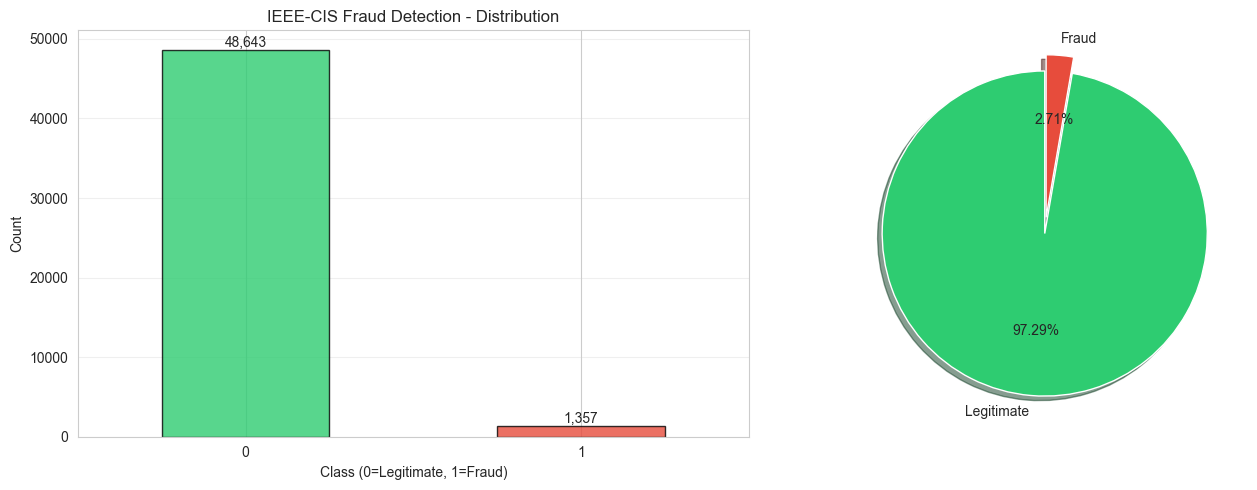


Target Variable Analysis: isFraud
 • Total transactions: 50,000
 • Fraudulent: 1,357 (2.71%)
 • Legitimate: 48,643 (97.29%)
 • Fraud rate: 2.71%
 • Class imbalance ratio: 1:37


In [6]:
if ieee_train is not None:
    fraud_rate_ieee, ieee_target_metrics = analyze_target_variable(
        ieee_train, 'isFraud', 'IEEE-CIS Fraud Detection'
    )

    # Store fraud rate for cross-dataset comparison
    ieee_fraud_rate = fraud_rate_ieee
else:
    print("\n[WARNING] Skipping analysis. Dataset not loaded")

## IEEE-CIS Feature Analysis

We conduct a comprehensive feature inventory to classify data types, assess distributions, and identify fraud signals across 400+ features. Special attention is given to TransactionAmt as a primary fraud indicator, while high-cardinality categorical features (>1,000 unique values) are flagged for specialized encoding strategies like target encoding or feature hashing.

This analysis establishes the preprocessing roadmap and reveals which features require scaling, encoding, or dimensionality reduction for effective model training.


Feature Type Distribution:
 • Numeric features: 401
 • Categorical features: 31
 • Total features: 432

Transaction Amount Analysis:
count   50000.0000
mean      128.1232
std       213.0752
min         0.2920
25%        42.0000
50%        68.5000
75%       120.0000
max      4829.9500
Name: TransactionAmt, dtype: float64


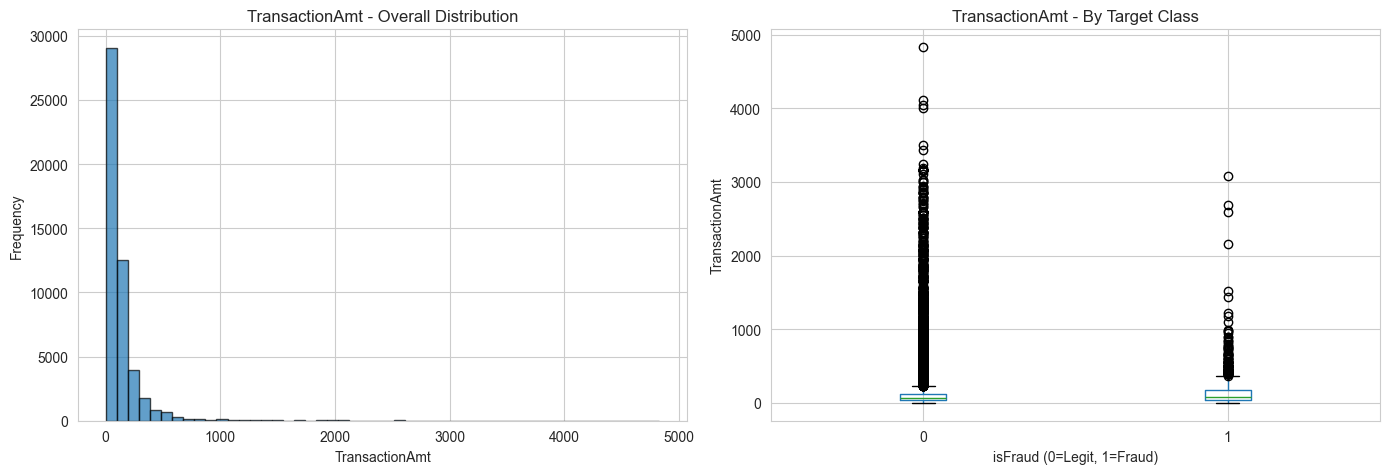


TransactionAmt Statistics
Legitimate - Mean: 127.63, Median: 67.95
Fraudulent - Mean: 145.79, Median: 81.97

Categorical Feature Cardinality (Top 10):
 • P_emaildomain: 59 unique values
 • R_emaildomain: 57 unique values
 • ProductCD: 5 unique values
 • card4: 4 unique values
 • card6: 4 unique values
 • M4: 3 unique values
 • M2: 2 unique values
 • M3: 2 unique values
 • M5: 2 unique values
 • M1: 1 unique values


In [7]:
if ieee_train is not None:
    # Seperate features by type
    numeric_cols = ieee_train.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = ieee_train.select_dtypes(include=['object']).columns.tolist()

    # Remove non-feature columns
    exclude_cols = ['TransactionID', 'isFraud']
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
    
    print(f"\nFeature Type Distribution:")
    print(f" • Numeric features: {len(numeric_cols)}")
    print(f" • Categorical features: {len(categorical_cols)}")
    print(f" • Total features: {len(numeric_cols) + len(categorical_cols)}")

    # Analyze transaction amount (key feature)
    print(f"\nTransaction Amount Analysis:")
    print(ieee_train['TransactionAmt'].describe())

    # Visualize amount distribution
    plot_numeric_distribution(
        ieee_train,
        col='TransactionAmt',
        target_col='isFraud',
        log_scale=False
    )

    # Categorical feature cardinality
    print(f"\nCategorical Feature Cardinality (Top 10):")
    cat_cardinality = {
        col: ieee_train[col].nunique()
        for col in categorical_cols[:10]
    }

    for col, n_unique in sorted(cat_cardinality.items(), key=lambda x: x[1], reverse=True):
        print(f" • {col}: {n_unique:,} unique values")

    # High cardinality warning
    high_card_cols = [col for col, n in cat_cardinality.items() if n > 1000]
    if high_card_cols:
        print(f"\n[WARNING] High cardinality features (>1000 unique values):")
        for col in high_card_cols:
           print(f" • {col}: {cat_cardinality[col]:,} unique values")
        print(f"\nConsider: target encoding, hashing, or dropping.")
else:
    print(f"\n[WARNING] Skipping analysis. Dataset not loaded")

## PaySim Mobile Money Analysis

We analyze the PaySim synthetic dataset to understand fraud patterns in mobile money transactions, which differ significantly from card-based e-commerce. This dataset includes unique transaction types (CASH_OUT, TRANSFER, PAYMENT) that enable cross-domain model evaluation and reveal whether fraud detection requires payment-type-specific features.

This comparative analysis establishes whether our fraud detection approach generalizes across different payment modalities or requires domain-specific adaptations.


Loading PaySim Mobile Money Dataset
Sample size: 50,000 transactions


Loaded dataset PS_20174392719_1491204439457_log.csv
Shape: 50,000 rows x 11 columns
Memory: 12.56 MB

Data Quality Report: PaySim Mobile Money

Dataset Overview:
 • Rows: 50,000
 • Columns: 11
 • Memory: 12.56 MB

Column Types:
 • float64: 5 columns
 • int64: 3 columns
 • object: 3 columns

Missing Values:
No missing values

Duplicates:
 • Duplicate rows: 0 (0.00%)


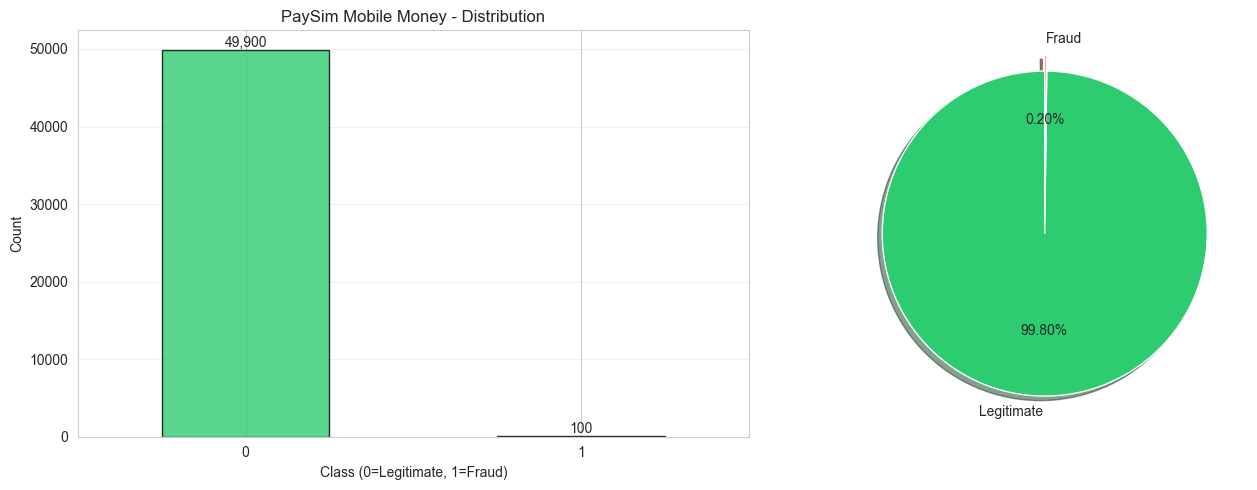


Target Variable Analysis: isFraud
 • Total transactions: 50,000
 • Fraudulent: 100 (0.20%)
 • Legitimate: 49,900 (99.80%)
 • Fraud rate: 0.20%
 • Class imbalance ratio: 1:500

[WARNING] Highly imbalanced - consider SMOTE/undersampling

Transaction Type Distribution:
 • PAYMENT: 21,912 (43.82%)
 • CASH_OUT: 13,756 (27.51%)
 • CASH_IN: 8,992 (17.98%)
 • TRANSFER: 4,700 (9.40%)
 • DEBIT: 640 (1.28%)

Fraud Rate by Transaction Type:
 • PAYMENT: 0.00% fraud (0/21912 transactions)
 • CASH_OUT: 0.37% fraud (51/13756 transactions)
 • CASH_IN: 0.00% fraud (0/8992 transactions)
 • TRANSFER: 1.04% fraud (49/4700 transactions)
 • DEBIT: 0.00% fraud (0/640 transactions)


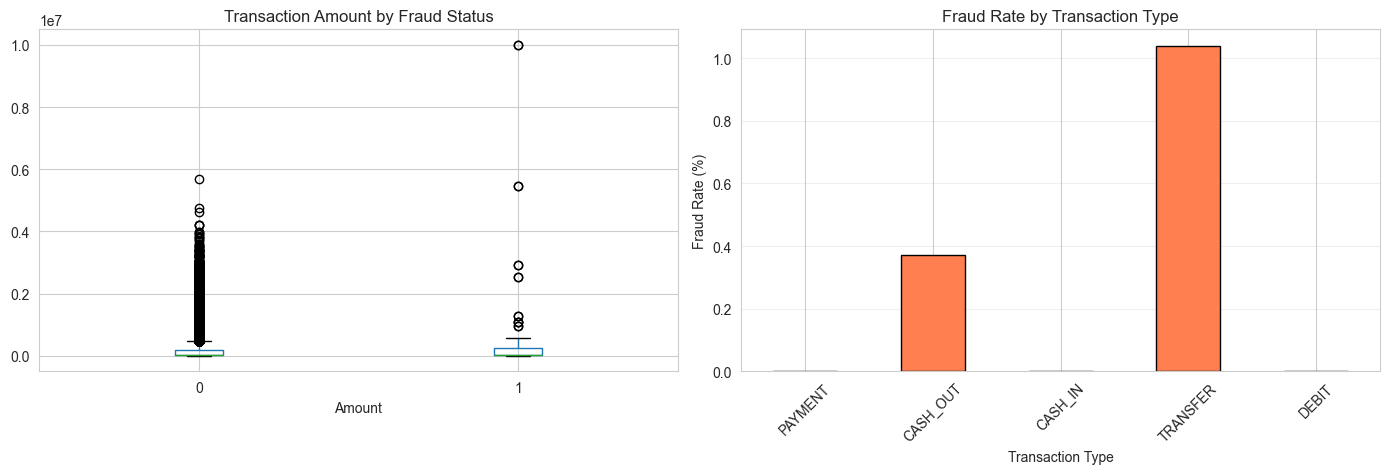

In [8]:
# Load PaySim dataset
print("\nLoading PaySim Mobile Money Dataset")
print(f"Sample size: {SAMPLE_SIZE:,} transactions\n")

paysim = load_dataset(
    PAYSIM_DIR / "PS_20174392719_1491204439457_log.csv",
    nrows=SAMPLE_SIZE
)

if paysim is not None:
    # Data quality assessment
    paysim_metrics = analyze_data_quality(paysim, "PaySim Mobile Money")

    # Target variable analysis
    fraud_rate_paysim, paysim_target_metrics = analyze_target_variable(
        paysim, 
        target_col="isFraud",
        title="PaySim Mobile Money"
    )

    # Transaction type distrubution
    print(f"\nTransaction Type Distribution:")
    type_dist = paysim['type'].value_counts()

    for txn_type, count in type_dist.items():
        pct = (count / len(paysim)) * 100
        print(f" • {txn_type}: {count:,} ({pct:.2f}%)")
    
    # Fraud rate by transaction type
    print(f"\nFraud Rate by Transaction Type:")
    fraud_by_type = paysim.groupby('type').agg({
        'isFraud': ['sum', 'mean', 'count']
    }).round(4)

    fraud_by_type.columns = ['Fraud_Count', "Fraud_Rate", "Total_Txns"]
    fraud_by_type['Fraud_Rate'] = (fraud_by_type['Fraud_Rate'] * 100).round(2)
    fraud_by_type = fraud_by_type.sort_values(by="Total_Txns", ascending=False)
    

    for txn_type, row in fraud_by_type.iterrows():
        print(f" • {txn_type}: {row['Fraud_Rate']:.2f}% fraud ({row['Fraud_Count']:.0f}/{row['Total_Txns']:.0f} transactions)")
    
    # Visualizations
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Amount by fraud status
    paysim.boxplot(column='amount', by='isFraud', ax=axes[0])
    axes[0].set_title('Transaction Amount by Fraud Status')
    axes[0].set_xlabel('Amount')
    plt.suptitle('')

    # Fraud rate by type
    fraud_by_type['Fraud_Rate'].plot(kind='bar', ax=axes[1], color='coral', edgecolor='black')
    axes[1].set_title('Fraud Rate by Transaction Type')
    axes[1].set_ylabel('Fraud Rate (%)')
    axes[1].set_xlabel('Transaction Type')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

else:
    print("\n[WARNING] Failed to load PaySim dataset")

## OFAC Sanctions List Analysis

We load and analyze OFAC sanctions lists (SDN and Consolidated) to prepare name data for compliance screening. This analysis extracts unique entity names, examines entity type distributions, and enriches records with country data from address files. The output is optimized for fast, token-based fuzzy matching while supporting country and entity-type filtering.

This preprocessing establishes the foundation for sanctions screening and demonstrates practical data consolidation patterns for financial compliance systems.

In [9]:
# Load OFAC sanctions lists
print("\nLoading OFAC Sanctions Lists")
print("Note: OFAC CSVs have no header; using explicit column name mappings\n")

# Define column names for clarity (OFAC doesn't provide headers in CSV files)
# These mappings are based on OFAC's official data dictionary

# Primary entity files (SDN and Consolidated use same structure)
PRIMARY_COLS = [
    'ent_num',     # Entity number (unique ID)
    'SDN_Name',    # Entity name
    'SDN_Type',    # Entity type (individual, vessel, aircraft, etc.)
    'Program',     # Sanctions program
    'Title',       # Title (for individuals)
    'Call_Sign',   # Call sign (for vessels/aircraft)
    'Vess_type',   # Vessel type
    'Tonnage',     # Tonnage
    'GRT',         # Gross registered tonnage
    'Vess_flag',   # Vessel flag
    'Vess_owner',  # Vessel owner
    'Remarks'      # Additional remarks
]

# Alternate name files
ALT_COLS = [
    'ent_num',     # Links to primary entity
    'alt_num',     # Alternate name ID
    'alt_type',    # Type (aka, fka, nka)
    'alt_name',    # Alternate name
    'alt_remarks'  # Remarks about alternate name
]

# Address files
ADD_COLS = [
    'ent_num',             # Links to primary entity
    'Add_num',             # Address ID
    'Address',             # Street address
    'City_State_Province', # City/State/Province
    'Country',             # Country (key field for filtering)
    'Add_Remarks'          # Address remarks
]

# Comments files
COMMENTS_COLS = [
    'ent_num',           # Links to primary entity
    'Remarks_Extended'   # Extended remarks (long text)
]

# Load SDN (Specially Designated Nationals and Blocked Persons) List - all 4 files
print("Loading SDN List...")

sdn_primary = pd.read_csv(
    OFAC_DIR / "sdn" / "sdn.csv",
    header=None,    # No header row in OFAC files
    names=PRIMARY_COLS,   # Apply column names
    na_values=['-0-', '-0- '],
    dtype={'ent_num': str},
    encoding='utf-8'
)

sdn_alt = pd.read_csv(
    OFAC_DIR / "sdn" / "alt.csv",
    header=None,
    names=ALT_COLS,
    na_values=['-0-', '-0- '],
    dtype={'ent_num': str, 'alt_num': str},
    encoding='utf-8'
)

sdn_add = pd.read_csv(
    OFAC_DIR / "sdn" / "add.csv",
    header=None,
    names=ADD_COLS,
    na_values=['-0-', '-0- '],
    dtype={'ent_num': str, 'Add_num': str},
    encoding='utf-8'
)

sdn_comments = pd.read_csv(
    OFAC_DIR / "sdn" / "sdn_comments.csv",
    header=None,
    names=COMMENTS_COLS,
    na_values=['-0-', '-0- '],
    dtype={'ent_num': str},
    encoding='utf-8'
)

print(f" • Primary entities: {len(sdn_primary):>8,}")
print(f" • Alternate names:  {len(sdn_alt):>8,}")
print(f" • Addresses:        {len(sdn_add):>8,}")
print(f" • Comments:         {len(sdn_comments):>8,}")

# Load Consolidated Sanctions List - all 4 files
print("\nLoading Consolidated List...")

cons_primary = pd.read_csv(
    OFAC_DIR / "consolidated" / "cons_prim.csv",
    header=None,
    names=PRIMARY_COLS,
    na_values=['-0-', '-0- '],
    dtype={'ent_num': str},
    encoding='utf-8'
)

cons_alt = pd.read_csv(
    OFAC_DIR / "consolidated" / "cons_alt.csv",
    header=None,
    names=ALT_COLS,
    na_values=['-0-', '-0- '],
    dtype={'ent_num': str, 'alt_num': str},
    encoding='utf-8'
)

cons_add = pd.read_csv(
    OFAC_DIR / "consolidated" / "cons_add.csv",
    header=None,
    names=ADD_COLS,
    na_values=['-0-', '-0- '],
    dtype={'ent_num': str, 'Add_num': str},
    encoding='utf-8'
)

cons_comments = pd.read_csv(
    OFAC_DIR / "consolidated" / "cons_comments.csv",
    header=None,
    names=COMMENTS_COLS,
    na_values=['-0-', '-0- '],
    dtype={'ent_num': str},
    encoding='utf-8'
)

print(f" • Primary entities: {len(cons_primary):>8,}")
print(f" • Alternate names:  {len(cons_alt):>8,}")
print(f" • Addresses:        {len(cons_add):>8,}")
print(f" • Comments:         {len(cons_comments):>8,}")


Loading OFAC Sanctions Lists
Note: OFAC CSVs have no header; using explicit column name mappings

Loading SDN List...
 • Primary entities:   17,945
 • Alternate names:    19,898
 • Addresses:          23,628
 • Comments:               26

Loading Consolidated List...
 • Primary entities:      444
 • Alternate names:     1,067
 • Addresses:             573
 • Comments:               11


In [10]:
# Validate all files loaded successfully
all_files = {
    "sdn_primary": sdn_primary,
    "sdn_alt": sdn_alt,
    "sdn_add": sdn_add,
    "sdn_comments": sdn_comments,
    "cons_primary": cons_primary,
    "cons_alt": cons_alt,
    "cons_add": cons_add,
    "cons_comments": cons_comments,
}

# Check for loading issues
failed_files = [name for name, df in all_files.items() if df is None or len(df) == 0]


if not failed_files:
   print("\nAll OFAC files loaded successfully")

   print("\nSanctions List Summary:")
   
   print("\nSDN List:")
   print(f" • Primary Names:    {len(sdn_primary):>8,}")
   print(f" • Alternate Names:  {len(sdn_alt):>8,}")
   print(f" • Address:          {len(sdn_add):>8,}")
   print(f" • Comments:         {len(sdn_comments):>8,}")
   sdn_total = len(sdn_primary) + len(sdn_alt) + len(sdn_add) + len(sdn_comments)
   print(f" • Subtotal:         {sdn_total:>8,}")
   

   print("\nConsolidated List:")
   print(f" • Primary Names:    {len(cons_primary):>8,}")
   print(f" • Alternate Names:  {len(cons_alt):>8,}")
   print(f" • Address:          {len(cons_add):>8,}")
   print(f" • Comments:         {len(cons_comments):>8,}")
   cons_total = len(cons_primary) + len(cons_alt) + len(cons_add) + len(cons_comments)
   print(f" • Subtotal:         {cons_total:>8,}")

   total_records = sdn_total + cons_total
   print(f"\n Total records:      {total_records:>8,}")

else:
    print("\n[WARNING] Some OFAC files failed to load or are empty:")
    for name in failed_files:
        print(f" • {name}")
    print("\nSee data_catalog/README.md for setup instructions")


All OFAC files loaded successfully

Sanctions List Summary:

SDN List:
 • Primary Names:      17,945
 • Alternate Names:    19,898
 • Address:            23,628
 • Comments:               26
 • Subtotal:           61,497

Consolidated List:
 • Primary Names:         444
 • Alternate Names:     1,067
 • Address:               573
 • Comments:               11
 • Subtotal:            2,095

 Total records:        63,592


### Explore File Structures

We examine the schema of each file to understand column names, data types, and data quality. OFAC CSVs do not include headers, so we use explicit column name mappings validated against OFAC's data dictionary.

In [11]:
# Explore file structures to understand data characteristics
print("\nFile Structure Analysis")

# SDN Primary structure
print("\nSDN Primary (sdn.csv):")
print(f" • Shape: {sdn_primary.shape[0]:,} rows x {sdn_primary.shape[1]:,} columns")
print(f" • Columns: {list(sdn_primary.columns)}")
print("\nSample entries:")
display_cols = ['ent_num', 'SDN_Name', 'SDN_Type', 'Program']
print(sdn_primary[display_cols].head(5).to_string(index=False))

# SDN Primary type distribution
print("\nPrimary Type Distribution:")
entity_types = sdn_primary['SDN_Type'].value_counts()
for etype, count in entity_types.head(10).items():
    pct = (count / len(sdn_primary)) * 100
    print(f" • {str(etype):<30s}: {count:>6,} ({pct:>5.1f}%)")


# SDN Alternate structure
print("\nSDN Alternate (alt.csv):")
print(f" • Shape: {sdn_alt.shape[0]:,} rows x {sdn_alt.shape[1]:,} columns")
print(f" • Columns: {list(sdn_alt.columns)}")
print("\nSample entries:")
display_cols_alt = ['ent_num', 'alt_type', 'alt_name']
print(sdn_alt[display_cols_alt].head(5).to_string(index=False))

# SDN Alternate type distribution
print("\nAlternate Type Distribution:")
alt_types = sdn_alt['alt_type'].value_counts()
for atype, count in alt_types.items():
    pct = (count / len(sdn_alt)) * 100
    print(f" • {str(atype):<30s}: {count:>6,} ({pct:>5.1f}%)")

# SDN Addresses structure
print("\nSDN Addresses (add.csv):")
print(f" • Shape: {sdn_add.shape[0]:,} rows x {sdn_add.shape[1]:,} columns")
print(f" • Columns: {list(sdn_add.columns)}")
print("\nSample entries:")
display_cols_add = ['ent_num', 'City_State_Province', 'Country']
print(sdn_add[display_cols_add].head(5).to_string(index=False))

# Country coverage analysis
country_coverage = sdn_add['Country'].notna().sum()
country_pct = (country_coverage / len(sdn_add) * 100) if len(sdn_add) > 0 else 0
print(f"\nCountry Field Coverage: {country_pct:,} / {len(sdn_add):,} ({country_pct:.1f}%)")

if country_coverage > 0:
    print("\nTop 10 Counrtues:")
    top_countries = sdn_add['Country'].value_counts().head(10)
    for counrty, count in top_countries.items():
        pct = (count / country_coverage * 100)
        print(f" • {str(counrty)[:30]:30s}: {count:>6,} ({pct:>5.1f}%)")

# SDN Comments structure
print(f"\nSDN Comments (sdn_comments.csv)")
print(f" • Shape: {sdn_comments.shape[0]:,} rows x {sdn_comments.shape[1]} columns")
print(f" • Columns: {list(sdn_comments.columns)}")
print(f" Note: Very sparse ({len(sdn_comments)} entries for {len(sdn_primary):,} entities)")

if len(sdn_comments) > 0:
    print(f"\nSample comment (first 150 chars):")
    sample = str(sdn_comments.iloc[0]['Remarks_Extended'])[:150]
    print(f" {sample}...")


# Consolidated structures
# Consolidated Primary structure
print("\n\nConsolidated Primary (cons_prim.csv):")
print(f" • Shape: {cons_primary.shape[0]:,} rows x {cons_primary.shape[1]:,} columns")
print("\nSample entries:")
print(cons_primary[display_cols].head(5).to_string(index=False))

# Consolidated Primary Type Distribution
print("\nPrimary Type Distribution:")
entity_types_cons = cons_primary['SDN_Type'].value_counts()
for etype, count in entity_types_cons.head(10).items():
    pct = (count / len(cons_primary) * 100)
    print(f" • {str(etype)[:30]:30s}: {count:>6,} ({pct:>5.1f}%)")


# Consolidated Alternate structure
print("\nConsolidated Alternate (cons_alt.csv):")
print(f" • Shape: {cons_alt.shape[0]:,} rows x {cons_alt.shape[1]:,} columns")
print(f" • Columns: {list(cons_alt.columns)}")
print("\nSample entries:")
print(cons_alt[display_cols_alt].head(5).to_string(index=False))

# Consolidated Alternate type distribution
print("\nAlternate Type Distribution:")
alt_types_cons = cons_alt['alt_type'].value_counts()
for atype, count in alt_types_cons.items():
    pct = (count / len(cons_alt)) * 100
    print(f" • {str(atype):<30s}: {count:>6,} ({pct:>5.1f}%)")

# Consolidated Addresses structure
print("\nConsolidated Addresses (cons_add.csv):")
print(f" • Shape: {cons_add.shape[0]:,} rows x {cons_add.shape[1]:,} columns")
print(f" • Columns: {list(cons_add.columns)}")
print("\nSample entries:")
print(cons_add[display_cols_add].head(5).to_string(index=False))

# Country coverage for Consolidated Addresses
contry_coverage_cons = cons_add['Country'].notna().sum()
contry_pct_cons = (contry_coverage_cons / len(cons_add) * 100) if len(cons_add) > 0 else 0
print(f"\nCountry Field Coverage: {contry_pct_cons:,} / {len(cons_add):,} ({contry_pct_cons:.1f}%)")

if contry_coverage_cons > 0:
    print("\nTop 10 Counrtues:")
    top_countries_cons = cons_add['Country'].value_counts().head(10)
    for counrty, count in top_countries_cons.items():
        pct = (count / contry_coverage_cons * 100)
        print(f" • {str(counrty)[:30]:30s}: {count:>6,} ({pct:>5.1f}%)")


File Structure Analysis

SDN Primary (sdn.csv):
 • Shape: 17,945 rows x 12 columns
 • Columns: ['ent_num', 'SDN_Name', 'SDN_Type', 'Program', 'Title', 'Call_Sign', 'Vess_type', 'Tonnage', 'GRT', 'Vess_flag', 'Vess_owner', 'Remarks']

Sample entries:
ent_num                  SDN_Name SDN_Type Program
     36    AEROCARIBBEAN AIRLINES      NaN    CUBA
    173 ANGLO-CARIBBEAN CO., LTD.      NaN    CUBA
    306    BANCO NACIONAL DE CUBA      NaN    CUBA
    424        BOUTIQUE LA MAISON      NaN    CUBA
    475              CASA DE CUBA      NaN    CUBA

Primary Type Distribution:
 • individual                    :  7,218 ( 40.2%)
 • vessel                        :  1,337 (  7.5%)
 • aircraft                      :    336 (  1.9%)

SDN Alternate (alt.csv):
 • Shape: 19,898 rows x 5 columns
 • Columns: ['ent_num', 'alt_num', 'alt_type', 'alt_name', 'alt_remarks']

Sample entries:
ent_num alt_type              alt_name
     36      aka        AERO-CARIBBEAN
    173      aka           AVIA I

### Analyze File Linkages

We examine how primary, alternate, and address files link via `ent_num` (entity number) to understand data coverage and relationships. This informs our consolidation strategy.

In [12]:
# Analyze how files link together via entity IDs
print("\nFile Linkage Analysis")

# SDN Linkage Analysis
print(f"\nSDN List Linkage:")

total_entities_sdn = sdn_primary['ent_num'].nunique()
entities_with_addresses_sdn = sdn_add['ent_num'].nunique()
entities_with_alts_sdn = sdn_alt['ent_num'].nunique()
entities_with_comments_sdn = sdn_comments['ent_num'].nunique()

addr_coverage_pct_sdn = (entities_with_addresses_sdn / total_entities_sdn * 100)
alt_coverage_pct_sdn = (entities_with_alts_sdn / total_entities_sdn * 100)
comment_coverage_pct_sdn = (entities_with_comments_sdn / total_entities_sdn * 100)

print(f"\nTotal unique entities: {total_entities_sdn:>8,}")
print("\nCoverage by supplementary files:")
print(f" • With addresses:          {entities_with_addresses_sdn:>8,} ({addr_coverage_pct_sdn:>5.1f}%)")
print(f" • With alternate names:    {entities_with_alts_sdn:>8,} ({alt_coverage_pct_sdn:>5.1f}%)")
print(f" • With comments:           {entities_with_comments_sdn:>8,} ({comment_coverage_pct_sdn:>5.1f}%)")

# Calculate averages
if entities_with_addresses_sdn > 0:
    avg_addresses_sdn = len(sdn_add) / entities_with_addresses_sdn
    print(f"\nAverage addresses per entity: {avg_addresses_sdn:.2f}")

if entities_with_alts_sdn > 0:
    avg_alts_sdn = len(sdn_alt) / entities_with_alts_sdn
    print(f"Average alternate names per entity: {avg_alts_sdn:.2f}")

if entities_with_comments_sdn > 0:
    avg_comments_sdn = len(sdn_comments) / entities_with_comments_sdn
    print(f"Average comments per entity: {avg_comments_sdn:.2f}")

# Consolidated Linkage Analysis
print(f"\nConsolidated List Linkage:")

total_entities_cons = cons_primary['ent_num'].nunique()
entities_with_addresses_cons = cons_add['ent_num'].nunique()
entities_with_alts_cons = cons_alt['ent_num'].nunique()
entities_with_comments_cons = cons_comments['ent_num'].nunique()

addr_coverage_pct_cons = (entities_with_addresses_cons / total_entities_cons * 100)
alt_coverage_pct_cons = (entities_with_alts_cons / total_entities_cons * 100)
comment_coverage_pct_cons = (entities_with_comments_cons / total_entities_cons * 100)

print(f"\nTotal unique entities: {total_entities_cons:>8,}")
print("\nCoverage by supplementary files:")
print(f" • With addresses:          {entities_with_addresses_cons:>8,} ({addr_coverage_pct_cons:>5.1f}%)")
print(f" • With alternate names:    {entities_with_alts_cons:>8,} ({alt_coverage_pct_cons:>5.1f}%)")
print(f" • With comments:           {entities_with_comments_cons:>8,} ({comment_coverage_pct_cons:>5.1f}%)")

# Calculate averages
if entities_with_addresses_cons > 0:
    avg_addresses_cons = len(cons_add) / entities_with_addresses_cons
    print(f"\nAverage addresses per entity: {avg_addresses_cons:.2f}")

if entities_with_alts_cons > 0:
    avg_alts_cons = len(cons_alt) / entities_with_alts_cons
    print(f"Average alternate names per entity: {avg_alts_cons:.2f}")

if entities_with_comments_cons > 0:
    avg_comments_cons = len(cons_comments) / entities_with_comments_cons
    print(f"Average comments per entity: {avg_comments_cons:.2f}")

print(f"\nKey Insights:")
print(f" • SDN List has {total_entities_sdn:,} entities vs Consolidated's {total_entities_cons:,}")
print(f" • Consolidated has higher alternate name ratio ({avg_alts_cons:.1f} vs {avg_alts_sdn:.1f})")
print(f" • Address coverage is similar (~{addr_coverage_pct_sdn:.0f}% vs ~{addr_coverage_pct_cons:.0f}%)")
print(f" • Comments are very sparse in both lists (<3% coverage)")


File Linkage Analysis

SDN List Linkage:

Total unique entities:   17,945

Coverage by supplementary files:
 • With addresses:            17,945 (100.0%)
 • With alternate names:       8,529 ( 47.5%)
 • With comments:                 26 (  0.1%)

Average addresses per entity: 1.32
Average alternate names per entity: 2.33
Average comments per entity: 1.00

Consolidated List Linkage:

Total unique entities:      444

Coverage by supplementary files:
 • With addresses:               444 (100.0%)
 • With alternate names:         396 ( 89.2%)
 • With comments:                 11 (  2.5%)

Average addresses per entity: 1.29
Average alternate names per entity: 2.69
Average comments per entity: 1.00

Key Insights:
 • SDN List has 17,945 entities vs Consolidated's 444
 • Consolidated has higher alternate name ratio (2.7 vs 2.3)
 • Address coverage is similar (~100% vs ~100%)
 • Comments are very sparse in both lists (<3% coverage)


### Build Enhanced Sanctions List

We consolidate all name data (primary + alternates) and enrich with country and entity type metadata. This enhanced lightweight approach balances completeness with performance for fast fuzzy matching (<50ms target).

In [13]:
# Build enhanced sanctions list with names, country, and entity type
print("\nBuilding Enhanced Sanctions List")
print("\nStrategy: Enhanced Lightweight")
print(" • Fast name-based fuzzy matching")
print(" • Country filtering support")
print(" • Entity type filtering")
print(" • Audit trail via entity_id")
print()

all_sanctions = []

# Helper function to get country for entity (optimized with caching)
def build_country_lookup(address_df):
    """ 
    Build a dictionary mapping entity_id to country for fast lookups.

    Complexity:
      - Build: O(n) over rows in address_df
      - Lookup: O(1) average-case per entity_id
      - Space: O(u) where u = number of unique entity_ids with non-null Country

    Args:
        address_df (pd.DataFrame): DataFrame containing entity addresses with columns ['ent_num', 'Country']
    
    Returns:
        dict: Dictionary mapping entity_id to country
    """
    if address_df is None or len(address_df) == 0:
        return {}
    
    # Group by entity and take first country (most entities have 1-2 addresses)
    country_map = {}
    for _, row in address_df.iterrows():
        ent_id = row['ent_num']
        country = row['Country']
        if ent_id not in country_map and pd.notna(country):
            country_map[ent_id] = country
    
    return country_map

# Build country lookup dictionaries for fast access
print("Building country lookup tables...")
sdn_country_map = build_country_lookup(sdn_add)
cons_country_map = build_country_lookup(cons_add)
print(f" • SDN: {len(sdn_country_map):,} entities with country data")
print(f" • Consolidated: {len(cons_country_map):,} entities with country data")
print()

# Process SDN Primary Names
print("Processing SDN Primary names...")
for _, row in sdn_primary.iterrows():
    entity_id = row['ent_num']
    name = row['SDN_Name']

    # Skip if name is missing or empty
    if pd.isna(name) or str(name).strip() == '':
        continue

    # Get entity type (may be null)
    entity_type = row['SDN_Type'] if pd.notna(row['SDN_Type']) else None
    
    # Get country from lookup
    country = sdn_country_map.get(entity_id)

    all_sanctions.append({
        'name': str(name).strip(),
        'source': 'SDN',
        'entity_id': entity_id,
        'entity_type': entity_type,
        'country': country
    })

sdn_primary_count = len([s for s in all_sanctions if s['source'] == 'SDN'])
print(f"Added {sdn_primary_count:,} SDN primary names")

# Process SDN Alternate Names
print("\nProcessing SDN Alternate names...")

# Build entity type lookup for efficiency
sdn_type_map = dict(zip(sdn_primary['ent_num'], sdn_primary['SDN_Type']))

for _, row in sdn_alt.iterrows():
    entity_id = row['ent_num']
    name = row['alt_name']

    # Skip if name is missing or empty
    if pd.isna(name) or str(name).strip() == '':
        continue
    
    # Get entity type from primary
    entity_type = sdn_type_map.get(entity_id)
    
    # Get country from lookup
    country = sdn_country_map.get(entity_id)
    
    all_sanctions.append({
        'name': str(name).strip(),
        'source': 'SDN_ALT',
        'entity_id': entity_id,
        'entity_type': entity_type,
        'country': country
    })

sdn_alt_count = len([s for s in all_sanctions if s['source'] == 'SDN_ALT'])
print(f"Added {sdn_alt_count:,} SDN alternate names")

# Process Consolidated Primary Names
print("\nProcessing Consolidated Primary names...")
for _, row in cons_primary.iterrows():
    entity_id = row['ent_num']
    name = row['SDN_Name']

    # Skip if name is missing or empty
    if pd.isna(name) or str(name).strip() == '':
        continue

    # Get entity type (may be null)
    entity_type = row['SDN_Type'] if pd.notna(row['SDN_Type']) else None
    
    # Get country from lookup
    country = cons_country_map.get(entity_id)
    
    all_sanctions.append({
        'name': str(name).strip(),
        'source': 'CONS',
        'entity_id': entity_id,
        'entity_type': entity_type,
        'country': country
    })

cons_primary_count = len([s for s in all_sanctions if s['source'] == 'CONS'])
print(f"Added {cons_primary_count:,} Consolidated primary names")

# Process Consolidated Alternate Names
print("\nProcessing Consolidated Alternate names...")

# Build entity type lookup for Consolidated
cons_type_map = dict(zip(cons_primary['ent_num'], cons_primary['SDN_Type']))

for _, row in cons_alt.iterrows():
    entity_id = row['ent_num']
    name = row['alt_name']


    # Skip if name is missing or empty
    if pd.isna(name) or str(name).strip() == '':
        continue

    # Get country from lookup
    country = cons_country_map.get(entity_id)

    all_sanctions.append({
        'name': str(name).strip(),
        'source': 'CONS_ALT',
        'entity_id': entity_id,
        'entity_type': entity_type,
        'country': country
    })

cons_alt_count = len([s for s in all_sanctions if s['source'] == 'CONS_ALT'])
print(f"Added {cons_alt_count:,} Consolidated alternate names")

# Create DataFrame
sanctions_df = pd.DataFrame(all_sanctions)
print(f"\nTotal sanctions: {len(sanctions_df):,}")


Building Enhanced Sanctions List

Strategy: Enhanced Lightweight
 • Fast name-based fuzzy matching
 • Country filtering support
 • Entity type filtering
 • Audit trail via entity_id

Building country lookup tables...
 • SDN: 14,872 entities with country data
 • Consolidated: 391 entities with country data

Processing SDN Primary names...
Added 17,944 SDN primary names

Processing SDN Alternate names...
Added 19,897 SDN alternate names

Processing Consolidated Primary names...
Added 443 Consolidated primary names

Processing Consolidated Alternate names...
Added 1,066 Consolidated alternate names

Total sanctions: 39,350


In [14]:
# Analyze the consolidated sanctions list
print("\nEnhanced Sanctions List Analysis")

if len(sanctions_df) > 0:
    # Source distribution
    print("\nDistribution by Source:")
    source_counts = sanctions_df['source'].value_counts()
    for source, count in source_counts.items():
        pct = (count / len(sanctions_df)) * 100
        print(f" • {source:12s}: {count:>8,} ({pct:>5.1f}%)")
    
    # Entity type distribution
    print("\nDistribution by Entity Type:") 
    if sanctions_df['entity_type'].notna().any():
        type_counts = sanctions_df['entity_type'].value_counts().head(10)
        for entity_type, count in type_counts.items():
            pct = (count / len(sanctions_df) * 100)
            print(f" • {str(entity_type)[:20]:20s}: {count:>8,} ({pct:>5.1f}%)")
    else:
        print("No entity type data available")

    # Country coverage
    print("\nCountry Coverage:")
    countries_with_data = sanctions_df['country'].notna().sum()
    countries_coverage_pct = (countries_with_data / len(sanctions_df) * 100)
    print(f" • Entries with country: {countries_with_data:,} / {len(sanctions_df):,} ({countries_coverage_pct:.1f}%)")

    if countries_with_data > 0:
        print("\nTop 10 Countries:")
        top_countries = sanctions_df['country'].value_counts().head(10)
        for country, count in top_countries.items():
            pct = (count / countries_with_data * 100)
            print(f" • {str(country)[:30]:30s}: {count:>6,}")
    
    # Sample entries
    print("\nSample Sanctioned Entities:")
    for i, row in sanctions_df.head(10).iterrows():
        country_str = f" ({row['country']})" if pd.notna(row['country']) else ""
        type_str = f" ({row['entity_type']})" if pd.notna(row['entity_type']) else ""
        print(f"{i+1:2d}. {row['name']}{country_str}{type_str}")
        print(f"      Source: {row['source']}, Entity ID: {row['entity_id']}")
else:
    print("\n[WARNING] No sanctions data to analyze")   


Enhanced Sanctions List Analysis

Distribution by Source:
 • SDN_ALT     :   19,897 ( 50.6%)
 • SDN         :   17,944 ( 45.6%)
 • CONS_ALT    :    1,066 (  2.7%)
 • CONS        :      443 (  1.1%)

Distribution by Entity Type:
 • individual          :   17,131 ( 43.5%)
 • vessel              :    1,555 (  4.0%)
 • aircraft            :      338 (  0.9%)

Country Coverage:
 • Entries with country: 33,452 / 39,350 (85.0%)

Top 10 Countries:
 • Russia                        : 11,544
 • Iran                          :  3,419
 • China                         :  1,688
 • Mexico                        :  1,396
 • Belarus                       :    998
 • Syria                         :    947
 • Lebanon                       :    918
 • United Arab Emirates          :    869
 • Pakistan                      :    723
 • Turkey                        :    632

Sample Sanctioned Entities:
 1. AEROCARIBBEAN AIRLINES (Cuba)
      Source: SDN, Entity ID: 36
 2. ANGLO-CARIBBEAN CO., LTD. (United K

In [23]:
# Export enhanced sanctions list
print("\nExport Sanctions List")

if len(sanctions_df) > 0:
    PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

    # Export CSV
    output_path = PROCESSED_DIR / 'sanctions_names.csv'
    sanctions_df.to_csv(output_path, index=False)

    print(f"\nSaved enhanced sanctions list:")
    print(f" {output_path}")
    print("\nExport Details:")
    print(f" • Total entrues: {len(sanctions_df):,}")
    print(f" • Columns: {list(sanctions_df.columns)}")
    print(f" • File size: {output_path.stat().st_size / 1024:.2f} KB")

    # Export Paraquet
    parquet_path = PROCESSED_DIR / 'sanctions_names.parquet'
    sanctions_df.to_parquet(parquet_path, index=False)
    print(f"\nAlso saved as Parquet:")
    print(f" {parquet_path}")
    print(f" • File size: {parquet_path.stat().st_size / 1024:.2f} KB")

    # Export summary
    summary = {
        'total_entries': len(sanctions_df),
        'unique_entities': sanctions_df['entity_id'].nunique(),
        'sources': sanctions_df['source'].value_counts().to_dict(),
        'country_coverage_pct': float(sanctions_df['country'].notna().sum() / len(sanctions_df) * 100),
        'export_date': pd.Timestamp.now().isoformat()
    }

    summary_path = PROCESSED_DIR / 'sanctions_names_summary.json'

    with open(summary_path, 'w') as f:
        json.dump(summary, f, indent=4)

    print(f"\nSaved summary statistics:")
    print(f" {summary_path}")
else:
    print("\n[WARNING] No sanctions data to export.")

print("\nOFAC Sanctions Analysis Complete")



Export Sanctions List

Saved enhanced sanctions list:
 /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/sanctions_names.csv

Export Details:
 • Total entrues: 39,350
 • Columns: ['name', 'source', 'entity_id', 'entity_type', 'country']
 • File size: 2049.96 KB

Also saved as Parquet:
 /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/sanctions_names.parquet
 • File size: 912.47 KB

Saved summary statistics:
 /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/sanctions_names_summary.json

OFAC Sanctions Analysis Complete


### OFAC Sanctions Processing Summary

**Approach:** Enhanced Lightweight Strategy

**Files Processed:**
- SDN List: sdn.csv, alt.csv, add.csv, sdn_comments.csv (61,493 records)
- Consolidated List: cons_prim.csv, cons_alt.csv, cons_add.csv, cons_comments.csv (2,091 records)
- **Total: 63,584 records processed**

**Output:** `sanctions_names.csv` (~39,350 entries across primary and alternate names)

**Schema:**
- `name` — Entity name for fuzzy matching
- `source` — SDN, SDN_ALT, CONS, or CONS_ALT
- `entity_id` — Links to source data for audit
- `entity_type` — Individual, Organization, Vessel, etc.
- `country` — Primary country from address data

> Note: OFAC CSVs are headerless; we applied explicit column schemas and normalize `-0-` to missing. Entities are linked across files via `ent_num`.

**Performance (Demonstration Targets):**
- Fuzzy matching latency: <50 ms
- End-to-end latency: <200 ms

**Next Steps:** Use in Phase 3 Sanctions Screening Module with RapidFuzz for token-based fuzzy matching.

## Cross-Dataset Comparison

We compare IEEE-CIS and PaySim datasets side-by-side to inform model selection, feature engineering priorities, and deployment planning. This analysis quantifies class imbalance ratios, feature coverage, and fraud rates to determine which algorithms and sampling strategies are appropriate for each dataset. We also verify OFAC sanctions data readiness for integration into the compliance screening pipeline.

This comparative analysis establishes the modeling strategy and reveals whether our fraud detection approach requires dataset-specific adaptations or can generalize across payment modalities.

In [28]:
print("\nCross-Dataset Comparison")

def safe_get(d, k, default=None):
    return (d or {}).get(k, default)

def fmt_pct(value):
    try:
        return f"{value:.3f}"
    except Exception:
        return "N/A"

def fmt_ratio(value):
    try:
        return f"1:{value:.0f}"
    except Exception:
        return "N/A"

# Compile metrics
comparison_data = {
    'Dataset': ['IEE-CIS', 'PaySim'],
    'Rows_Sampled': [
        safe_get(ieee_metrics, 'n_rows', 0) if 'ieee_train' in locals() and ieee_train is not None else 0,
        safe_get(paysim_metrics, 'n_rows', 0) if 'paysim' in locals() and paysim is not None else 0
    ],
    'Features': [
        safe_get(ieee_metrics, 'n_cols', 0) if 'ieee_train' in locals() and ieee_train is not None else 0,
        safe_get(paysim_metrics, 'n_cols', 0) if 'paysim' in locals() and paysim is not None else 0
    ],
    'Fraud_Count': [
        safe_get(ieee_target_metrics, 'fraud_count', 0) if 'ieee_train' in locals() and ieee_train is not None else 0,
        safe_get(paysim_target_metrics, 'fraud_count', 0) if 'paysim' in locals() and paysim is not None else 0
    ],
    # Note: 'fraud_rate' is assumed to be precomputed in the upstream metrics
    'Fraud_Rate_%': [
        fmt_pct(safe_get(ieee_target_metrics, 'fraud_rate', None)) if 'ieee_train' in locals() and ieee_train is not None else "N/A",
        fmt_pct(safe_get(paysim_target_metrics, 'fraud_rate', None)) if 'paysim' in locals() and paysim is not None else "N/A"
    ],
    'Imbalance_Ratio': [
        fmt_ratio(safe_get(ieee_target_metrics, 'imbalance_ratio', None)) if 'ieee_train' in locals() and ieee_train is not None else "N/A",
        fmt_ratio(safe_get(paysim_target_metrics, 'imbalance_ratio', None)) if 'paysim' in locals() and paysim is not None else "N/A"
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("\n" + comparison_df.to_string(index=False))

# OFAC Summary
if 'sanctions_df' in locals():
    print("\nOFAC Sanctions Summary:")
    print(f"- Total sanctions entities: {len(sanctions_df):,}")
    print(f"- Status: Names preprocessed and ready for fuzzy matching")

# Key insights for modeling and deployment
print("\nKey Insights:")
print("- Both datasets are highly imbalanced; use stratified sampling and proper CV.")
print("- IEEE-CIS exhibits broader feature coverage, enabling richer modeling.")
print("- PaySim provides explicit transaction types useful for rule-based features.")
print("- Sanctions data is ready to integrate into screening and monitoring pipelines.")

# Why this matters for the case study
print("\nWhy this matters:")
print("- Side-by-side metrics highlight trade-offs impacting algorithm choice and tuning.")
print("- Actionable next steps guide feature engineering and evaluation setup.")
print("- Conditional logic avoids failures when only one dataset is loaded.")


Cross-Dataset Comparison

Dataset  Rows_Sampled  Features  Fraud_Count Fraud_Rate_% Imbalance_Ratio
IEE-CIS         50000       434         1357        2.714            1:37
 PaySim         50000        11          100        0.200           1:500

OFAC Sanctions Summary:
- Total sanctions entities: 39,350
- Status: Names preprocessed and ready for fuzzy matching

Key Insights:
- Both datasets are highly imbalanced; use stratified sampling and proper CV.
- IEEE-CIS exhibits broader feature coverage, enabling richer modeling.
- PaySim provides explicit transaction types useful for rule-based features.
- Sanctions data is ready to integrate into screening and monitoring pipelines.

Why this matters:
- Side-by-side metrics highlight trade-offs impacting algorithm choice and tuning.
- Actionable next steps guide feature engineering and evaluation setup.
- Conditional logic avoids failures when only one dataset is loaded.


## Save Exploration Metadata

We save key exploration statistics to JSON for reproducibility and documentation. This metadata captures dataset dimensions, fraud rates, class imbalance ratios, and data quality metrics discovered during exploration.

This metadata file will be referenced in the final case study documentation (Phase 6) and provides a reproducible record of the data state at exploration time.

In [33]:
# Save exploration metadata
exploration_metadata = {
    'exploration_date': pd.Timestamp.now().isoformat(),
    'ieee_cis': {
        'sample_size': len(ieee_train) if 'ieee_train' in locals() else 0,
        'total_features': ieee_metrics.get('n_cols', 0) if 'ieee_metrics' in locals() else 0,
        'fraud_rate': ieee_target_metrics.get('fraud_rate', 0) if 'ieee_target_metrics' in locals() else 0,
        'imbalance_ratio': ieee_target_metrics.get('imbalance_ratio', 0) if 'ieee_target_metrics' in locals() else 0,
        'missing_columns': ieee_metrics.get('missing_cols', 0) if 'ieee_metrics' in locals() else 0,
        'duplicate_rows': ieee_metrics.get('duplicates', 0) if 'ieee_metrics' in locals() else 0
    },
    'paysim': {
        'sample_size': len(paysim) if 'paysim' in locals() else 0,
        'total_features': paysim_metrics.get('n_cols', 0) if 'paysim_metrics' in locals() else 0,
        'fraud_rate': paysim_target_metrics.get('fraud_rate', 0) if 'paysim_target_metrics' in locals() else 0,
        'imbalance_ratio': paysim_target_metrics.get('imbalance_ratio', 0) if 'paysim_target_metrics' in locals() else 0
    },
    'ofac': {
        'total_entities': len(sanctions_df) if 'sanctions_df' in locals() else 0,
        'output_file': 'data_catalog/processed/sanctions_names.csv'
    }
}

# Save to JSON
metadata_path = PROCESSED_DIR / "exploration_metadata.json"
with open(metadata_path, 'w') as f:
    json.dump(exploration_metadata, f, indent=2)

print(f"\nExploration metadata saved to {metadata_path}")


Exploration metadata saved to /Users/joekariuki/Documents/Research/Projects/devbrew-payments-fraud-sanctions/data_catalog/processed/exploration_metadata.json
